In [1]:
device = "cpu"

# Prepare dataset

In [2]:
from datasets import load_dataset

/home/eranario/miniconda3/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_to_data = '/data2/eranario/data/Active-Learning-Datasets/Borden'

In [4]:
dataset = load_dataset('imagefolder', data_dir=path_to_data)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 98
    })
    validation: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 28
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 24
    })
})

In [6]:
dataset['train'][0].keys()

dict_keys(['image', 'image_id', 'width', 'height', 'objects'])

In [7]:
dataset['train'][0]['objects'].keys()

dict_keys(['bbox', 'categories'])

In [8]:
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

In [9]:
import numpy as np
from PIL import Image, ImageDraw

def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]
    
    for i in range(len(annotations["categories"])):
        box = annotations["bbox"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), str(annotations["categories"][i]), fill="white")
    return image

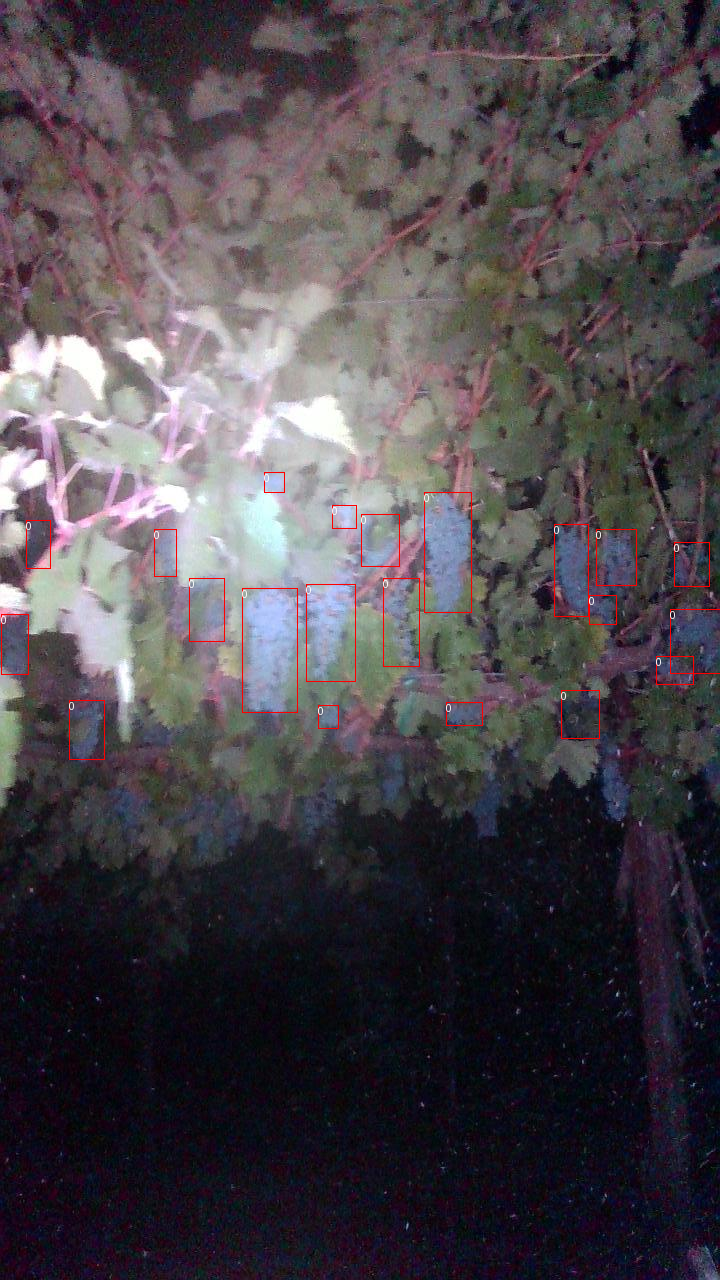

In [10]:
draw_image_from_idx(dataset=train_dataset, idx=10)

# Image Preprocessing

In [11]:
from transformers import AutoProcessor

In [12]:
model_id = "IDEA-Research/grounding-dino-tiny"
image_processor = AutoProcessor.from_pretrained(model_id)

In [13]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
)

In [14]:
def formatted_anns(image_id, category, bbox):
    annotations = []
    for i in range(len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [16]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("IDEA-Research/grounding-dino-tiny")

def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, categories = [], [], []
    
    for image, objects in zip(examples["image"], examples["objects"]):
        if 'categories' not in objects:
            print("Key 'categories' not found in objects")
    
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects['bbox'], categories=objects['categories'])

        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["categories"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, box_)}
        for id_, cat_, box_ in zip(image_ids, categories, bboxes)
    ]
    
    # Obtain pixel values
    processed = image_processor(images=images, annotations=targets, return_tensors="pt")
    pixel_values = processed["pixel_values"]
    
    # Create a dummy pixel mask with all ones (indicating all pixels are real)
    pixel_mask = torch.ones((pixel_values.shape[0], pixel_values.shape[2], pixel_values.shape[3]), dtype=torch.long)
    
    # Create input_ids from an empty string
    empty_prompt = ""
    encoded_prompt = tokenizer(empty_prompt, return_tensors="pt", padding="max_length", truncation=True)
    input_ids = encoded_prompt["input_ids"]
    attention_mask = encoded_prompt["attention_mask"]

    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }

train_dataset = train_dataset.with_transform(transform_aug_ann)
val_dataset = val_dataset.with_transform(transform_aug_ann)
test_dataset = test_dataset.with_transform(transform_aug_ann)


In [17]:
train_dataset = train_dataset.with_transform(transform_aug_ann)
val_dataset = val_dataset.with_transform(transform_aug_ann)
test_dataset = test_dataset.with_transform(transform_aug_ann)

In [18]:
train_dataset[0].keys()


dict_keys(['pixel_values', 'pixel_mask', 'input_ids', 'attention_mask'])

# Train your model

In [19]:
from transformers import AutoModelForZeroShotObjectDetection

In [20]:
id2label = {0: "grape"}
label2id = {v: k for k, v in id2label.items()}

In [21]:
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [22]:
from transformers import TrainingArguments
from transformers import Trainer


# Define the training arguments

training_args = TrainingArguments(
    output_dir="/data2/eranario/intermediate_data/Active-Learning/GroundingDINO_logs/test",
    per_device_train_batch_size=1,
    num_train_epochs=1,
    learning_rate=1e-5,
    remove_unused_columns=False
)

# Define the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

TypeError: Trainer.__init__() got an unexpected keyword argument 'device'